# MSDS 498 AI Capstone
# Melek Mizher
# Data used was sourced from Kaggle from two datasets.
#
#
#
## Car License Plate Detection General Dataset from Andrew Maranhão
### https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
## Car License Plate Classification US Dataset from Tolga Dinçer
### https://www.kaggle.com/datasets/tolgadincer/us-license-plates


# Required Libraries and Packages

In [ ]:
# Install Required Packages

#Data Processing Packages
#!pip install pandas
#!pip install matplotlib
#!pip install numpy
#!pip install seaborn
#!pip install pillow
#!pip install sklearn
#!pip install roboflow
#!pip install pillow
#!pip install cv2

In [3]:
#General Data Parsing and Processing Libraries
import os
import pandas as pd
import numpy as np
import wget

#Model and Image Manipulation
from roboflow import Roboflow
from PIL import Image, ImageFilter #Documentation https://pillow.readthedocs.io/en/stable/reference/Image.html
import cv2

#Data Visualization and Analysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# YOLOv8 Pretrained License Plate Recognition Model obtained from Roboflow

In [259]:
rf_plate_recognition = Roboflow(api_key="7sKB3g0AlwDmT8O6Ayzb")
project_plate_recognition = rf_plate_recognition.workspace().project("alpr-yolov8")
model_plate_recognition = project_plate_recognition.version(3).model

# infer on a local image
#print(model.predict("your_image.jpg", confidence=40, overlap=30).json())

# visualize your prediction
# model.predict("your_image.jpg", confidence=40, overlap=30).save("prediction.jpg")

url = "https://www.autolist.com/6tuem73u73an/1NTqf3b5A04SAc6MKA2GWs/3d74c346407875cd94ecbbee10bfef86/plate-1166-image.jpg"
file = wget.download(url)
im = Image.open(file)
# infer on an image hosted elsewhere
prediction = model_plate_recognition.predict(file, hosted=False, confidence=40, overlap=30).json()

loading Roboflow workspace...
loading Roboflow project...


In [260]:
# Function to extract the location of the license plate corners from Prediction JSON file
def plate_location(prediction):
    x = prediction['predictions'][0]['x'] #center at x
    y = prediction['predictions'][0]['y'] #center at y
    w = prediction['predictions'][0]['width']
    h = prediction['predictions'][0]['height']
    left = x-w/2
    upper = y-h/2
    right = x+w/2
    lower = y+h/2
    return left,upper,right,lower

# Example Cropping based on Prediction

In [261]:
left,upper,right,lower = plate_location(prediction)

In [262]:
left,upper,right,lower

(513.5, 330.5, 800.5, 549.5)

In [263]:
pre_plate = im.crop(plate_location(prediction))

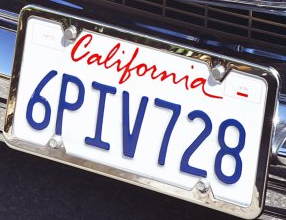

In [264]:
pre_plate

## Plate Image Processing

In [265]:
#Defines a 2D Fourier Transformation
def calculate_2dft(image_array):
    ft = np.fft.ifftshift(image_array)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    return ft

In [266]:
def process_plate_image(im):
    #with Image.open(image) as im: # Unnecessary as it is already an image
        w, h = im.size
        padding = int(max(w, h) * 0.3)  # Adjust the padding percentage as needed
        new_w = w + 2 * padding
        new_h = h + 2 * padding
        new_img = Image.new(im.mode, (new_w, new_h), (0,0,0))
        new_img.paste(im, (padding, padding), 0)
        #Produces an Image with Padding around it to allow rotations and to avoid Fourier wraparound artefact.
        new_img_gray = new_img.convert('L')
        #Turn into Grayscale
        threshold = 128
        new_img_binary = new_img_gray.point(lambda x: 255 if x > threshold else 0, '1')

        #Call in 2D Fourier Transformation
        ft = calculate_2dft(new_img_gray)

        # To transform the 2D Fourier Transform to the correct orientation; The necessary steps is to take the arctangent of the absolute value of the ratio of the Y coefficient over the x coefficient of the FFT.

        # Multiply Magnitude by 2nd order Circular Harmonic and Sum to generate the Complex Argument c.
        c = sum(sum(abs(ft)*ft[2,2]))

        #second_harmonic = ft[2,2] # There are two. One is for each dimension since it is a 2D image. Second Circular Harmonic of Fourier Transform. ft.imag[2,2] and ft.real[2,2] can be used to extract the imaginary and real components of the F.T.
        #Reference 1: https://dsp.stackexchange.com/questions/25482/extracting-direction-of-dominant-sinusoids-from-an-image-in-terms-of-angles
        #Reference 2: https://www.physicsforums.com/threads/2d-fourier-transform-orientation-angle.947794/

        #Calculate the Angle, which is half of the Angle of the Complex Argument c. deg = True turns this directly from radians to degrees in one step.
        tf_theta_deg = np.angle(c, deg=True)/2

        #Rotate the image and then crop is back to the original size
        processed_image = new_img_gray.rotate(tf_theta_deg, resample=Image.BICUBIC)

        # Smoothen image
        processed_image = processed_image.filter(ImageFilter.GaussianBlur(radius=0.2))  #0.8930


        # Crop image
        processed_image = processed_image.crop((padding, padding, padding + w, padding + h))
        return processed_image


![alt text](ftmath.png "Title")

In [267]:
plate = process_plate_image(pre_plate)
plate.save("plate.jpg")

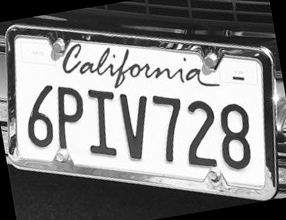

In [268]:
plate

In [269]:
pre_plate.save("pre_plate.jpg")
plate.save("pos_plate.jpg")

# Loading model to infer on processed license plate

In [270]:
rf_character_recognition = Roboflow(api_key="7sKB3g0AlwDmT8O6Ayzb")
project_character_recognition = rf_character_recognition.workspace().project("ocr-oy9a7")
model_character_recognition = project_character_recognition.version(1).model

# infer on a local image
prediction_pre = model_character_recognition.predict("pre_plate.jpg", confidence=80, overlap=30).json()
prediction_pos = model_character_recognition.predict("pos_plate.jpg", confidence=80, overlap=30).json()

loading Roboflow workspace...
loading Roboflow project...


In [271]:
prediction_pre

{'predictions': [{'x': 69.5,
   'y': 105.5,
   'width': 35.0,
   'height': 69.0,
   'confidence': 0.9173083305358887,
   'class': 'P',
   'image_path': 'pre_plate.jpg',
   'prediction_type': 'ObjectDetectionModel'},
  {'x': 167.0,
   'y': 135.0,
   'width': 34.0,
   'height': 76.0,
   'confidence': 0.9132896661758423,
   'class': '7',
   'image_path': 'pre_plate.jpg',
   'prediction_type': 'ObjectDetectionModel'},
  {'x': 230.0,
   'y': 151.0,
   'width': 38.0,
   'height': 74.0,
   'confidence': 0.9131073355674744,
   'class': '8',
   'image_path': 'pre_plate.jpg',
   'prediction_type': 'ObjectDetectionModel'},
  {'x': 134.0,
   'y': 128.0,
   'width': 36.0,
   'height': 78.0,
   'confidence': 0.9097492694854736,
   'class': 'V',
   'image_path': 'pre_plate.jpg',
   'prediction_type': 'ObjectDetectionModel'},
  {'x': 196.0,
   'y': 144.0,
   'width': 38.0,
   'height': 78.0,
   'confidence': 0.9089524745941162,
   'class': '2',
   'image_path': 'pre_plate.jpg',
   'prediction_type': '

In [272]:
predictions = prediction_pre['predictions']

In [273]:
predictions = sorted(predictions, key=lambda x: (x['x']))

In [274]:
final_prediction = [prediction['class'] for prediction in predictions]

In [275]:
final_prediction = ''.join(final_prediction)

In [276]:
final_prediction

'6PIV728'

In [277]:
final_prediction = [prediction['confidence'] for prediction in predictions]
final_prediction_confidence = np.mean(final_prediction)
final_prediction_confidence

0.9099115559032985

In [278]:
predictions = prediction_pos['predictions']
predictions = sorted(predictions, key=lambda x: (x['x']))
final_prediction = [prediction['class'] for prediction in predictions]
final_prediction = ''.join(final_prediction)
final_prediction

'6PIV728'

In [279]:
final_prediction = [prediction['confidence'] for prediction in predictions]
final_prediction_confidence = np.mean(final_prediction)
final_prediction_confidence

0.9223620125225612

In [280]:
final_prediction

[0.9116643071174622,
 0.938539981842041,
 0.9291000366210938,
 0.9222841262817383,
 0.9140172004699707,
 0.9236745834350586,
 0.917253851890564]

In [281]:
#Old version of the fourier process
"""
def fourier_process(plate_image, prediction):
    plate_image = plate_image.crop(plate_location(prediction))
    w, h = plate_image.size
    padding = int(max(w, h) * 0.3)  # Adjust the padding percentage as needed
    new_w = w + 2 * padding
    new_h = h + 2 * padding
    new_plate_image = Image.new(plate_image.mode, (new_w, new_h), (0,0,0))
    new_plate_image.paste(plate_image, (padding, padding), 0)
    #Convert to Grayscale
    new_gray_image = new_plate_image.convert('L')
    #Apply Fourier Transform
    ft = calculate_2dft(new_gray_image)
    # Multiply Magnitude by 2nd order Circular Harmonic and Sum to generate the Complex Argument c.
    c = sum(sum(abs(ft)*ft[2,2]))
    #Calculate the Angle, which is half of the Angle of the Complex Argument c. deg = True turns this directly from radians to degrees in one step.
    tf_theta_deg = np.angle(c, deg=True)/2
    #Rotate the image and then crop is back to the original size
    processed_image = new_gray_image.rotate(tf_theta_deg, resample=Image.BICUBIC)
    # Smoothen image
    processed_image = processed_image.filter(ImageFilter.GaussianBlur(radius=0.2))  #0.8930
    processed_image = processed_image.crop((padding, padding, padding + w, padding + h))
    return processed_image
    """

"\ndef fourier_process(plate_image, prediction):\n    plate_image = plate_image.crop(plate_location(prediction))\n    w, h = plate_image.size\n    padding = int(max(w, h) * 0.3)  # Adjust the padding percentage as needed\n    new_w = w + 2 * padding\n    new_h = h + 2 * padding\n    new_plate_image = Image.new(plate_image.mode, (new_w, new_h), (0,0,0))\n    new_plate_image.paste(plate_image, (padding, padding), 0)\n    #Convert to Grayscale\n    new_gray_image = new_plate_image.convert('L')\n    #Apply Fourier Transform\n    ft = calculate_2dft(new_gray_image)\n    # Multiply Magnitude by 2nd order Circular Harmonic and Sum to generate the Complex Argument c.\n    c = sum(sum(abs(ft)*ft[2,2]))\n    #Calculate the Angle, which is half of the Angle of the Complex Argument c. deg = True turns this directly from radians to degrees in one step.\n    tf_theta_deg = np.angle(c, deg=True)/2\n    #Rotate the image and then crop is back to the original size\n    processed_image = new_gray_image.

# Beginning of Actual Program including loading of Models, excluding Imports

In [282]:
rf_plate_recognition = Roboflow(api_key="7sKB3g0AlwDmT8O6Ayzb")
project_plate_recognition = rf_plate_recognition.workspace().project("alpr-yolov8")
model_plate_recognition = project_plate_recognition.version(3).model

rf_character_recognition = Roboflow(api_key="7sKB3g0AlwDmT8O6Ayzb")
project_character_recognition = rf_character_recognition.workspace().project("ocr-oy9a7")
model_character_recognition = project_character_recognition.version(1).model

loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...


In [283]:
# Function to extract the location of the license plate corners from Prediction JSON file
def plate_location(prediction):
    if 'predictions' in prediction and len(prediction['predictions']) > 0:
        x = prediction['predictions'][0]['x'] #center at x
        y = prediction['predictions'][0]['y'] #center at y
        w = prediction['predictions'][0]['width']
        h = prediction['predictions'][0]['height']
        left = int(x - w / 2)
        upper = int(y - h / 2)
        right = int(x + w / 2)
        lower = int(y + h / 2)
        return left, upper, right, lower
    else:
        return None

In [285]:
def fourier_process(plate_image, prediction):
    location = plate_location(prediction)
    if location is None:
        return None

    left, upper, right, lower = location
    plate_image = plate_image.crop((left, upper, right, lower))
    cropped_plate_array = np.array(plate_image)

    # Convert to grayscale
    new_gray_image = cv2.cvtColor(cropped_plate_array, cv2.COLOR_RGB2GRAY)

    # Perform Fourier Transform
    f = np.fft.fft2(new_gray_image)
    f_shift = np.fft.fftshift(f)

    # Calculate Center of Mass
    y_cm, x_cm = np.unravel_index(np.argmax(np.abs(f_shift)), f_shift.shape)

    # Calculate Angle of rotation
    rows, cols = new_gray_image.shape
    cy, cx = rows // 2, cols // 2
    dy = y_cm - cy
    dx = x_cm - cx
    angle_rad = np.arctan2(dy, dx)
    angle_deg = np.degrees(angle_rad)

    # Rotate the image
    processed_image = Image.fromarray(cropped_plate_array)
    processed_image = processed_image.rotate(angle_deg, resample=Image.BICUBIC)

    return processed_image

In [286]:
def soft_process(plate_image):
    new_img_gray = plate_image.convert('L')
    #Resample Image
    processed_image = new_img_gray.rotate(0, resample=Image.BICUBIC)
    # Smoothen image
    processed_image = processed_image.filter(ImageFilter.GaussianBlur(radius=0.2))  #0.8930
    return processed_image

In [287]:
def binary_process(plate_image):
    new_img_gray = plate_image.convert('L')
    #Resample Image
    processed_image = new_img_gray.rotate(0, resample=Image.BICUBIC)
    # Binary image
    threshold = 100
    processed_image = processed_image.point(lambda x: 255 if x > threshold else 0, '1')
    # Return to grayscale and smoothen
    processed_image = processed_image.convert('L')
    processed_image = processed_image.filter(ImageFilter.GaussianBlur(radius=0.75))
    return processed_image

In [288]:
def extract_lp_information(image_path, mode, sharpen=False):
    location_prediction = model_plate_recognition.predict(image_path, hosted=False, confidence=40, overlap=30).json()
    pre_plate = Image.open(image_path)
    if mode == "fourier":
        pos_plate = fourier_process(pre_plate, location_prediction)
        if pos_plate == None:
            return '', np.nan
    elif mode == "binary":
        pre_plate = binary_process(pre_plate)
        pos_plate = pre_plate.crop(plate_location(location_prediction))
    else:
        if sharpen:
            pre_plate = soft_process(pre_plate)
            pre_plate = pre_plate.filter(ImageFilter.SHARPEN())
            pos_plate = pre_plate.crop(plate_location(location_prediction))
        else:
            pre_plate = soft_process(pre_plate)
            pos_plate = pre_plate.crop(plate_location(location_prediction))

    if 'predictions' not in location_prediction or not location_prediction['predictions']:
        return '', np.nan

    pos_plate.save("pos_plate.png")
    prediction_pos = model_character_recognition.predict("pos_plate.png", confidence=60, overlap=30).json()
    predictions = prediction_pos.get('predictions', [])
    if not predictions:
        return '', np.nan

    predictions = sorted(predictions, key=lambda x: x['x'])
    final_prediction = ''.join([prediction['class'] for prediction in predictions])
    confidence_scores = [prediction['confidence'] for prediction in predictions]
    confidence_score = np.mean(confidence_scores)
    return final_prediction, confidence_score

In [289]:
extract_lp_information("plate-1166-image.jpg", mode="fourier")

('6PIV728', 0.908186137676239)

In [291]:
extract_lp_information("difficult.jpeg", mode="soft")

('Z7ZZ2Z7', 0.8712669100080218)

In [292]:
extract_lp_information("Cars216.png", mode="binary")

('OPECL0L', 0.866570268358503)

# Algorithm Running on Dataset

In [122]:
#Extract paths to all the files of interest

folder_path = 'Data/images/train/'
file_paths = os.listdir(folder_path)
png_files = [file_name for file_name in file_paths if file_name.endswith('.png')]
file_paths = [folder_path + file_path for file_path in png_files]

In [123]:
#New Dataframe that will contain results
results_df = pd.DataFrame()
results_df['file_path'] = file_paths

In [124]:
# zip(* unpacks the results into the two separate arguments
results_df['fourier_final_prediction'], results_df['fourier_confidence_score'] = zip(*results_df['file_path'].apply(lambda x: extract_lp_information(x, mode='fourier')))

In [125]:
results_df['soft_final_prediction'], results_df['soft_confidence_score'] = zip(*results_df['file_path'].apply(lambda x: extract_lp_information(x, mode='soft')))

In [126]:
results_df['binary_final_prediction'], results_df['binary_confidence_score'] = zip(*results_df['file_path'].apply(lambda x: extract_lp_information(x, mode='binary')))

In [127]:
#results_df.to_csv('results.csv', index=False)

# Processing of Results

In [242]:
results_df = pd.read_csv('results.csv')
labels_df = pd.read_csv('Data/images/labels.csv')

In [243]:
results_df

,file_path,fourier_final_prediction,fourier_confidence_score,soft_final_prediction,soft_confidence_score,binary_final_prediction,binary_confidence_score
0,Data/images/train/Cars207.png,8MYKOT0IH075ERTGVSRAORNE,0.820421,89MYKOGT0IH075ERTGVSRAORNE,0.799536,MYKOTDIH7F5ERGCRAR,0.767129
1,Data/images/train/Cars213.png,21D,0.780949,21D,0.767586,321D,0.662740
2,Data/images/train/Cars53.png,CHI00SE,0.886123,CHI00SE,0.885795,CWI00SE,0.847857
3,Data/images/train/Cars47.png,S799,0.855682,S799,0.853535,NaN,NaN
4,Data/images/train/Cars90.png,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
428,Data/images/train/Cars76.png,VHEA31RSS,0.865181,VHEA31RSS,0.864417,VHEA1RSS,0.842992
429,Data/images/train/Cars183.png,BRT000,0.841702,BRT000,0.855494,BRIT000,0.828244
430,Data/images/train/Cars197.png,LR33TEE,0.863861,LR33TEE,0.868166,LR33TEE,0.877679
431,Data/images/train/Cars236.png,NaN,NaN,NaN,NaN,NaN,NaN


In [244]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   file_path                 433 non-null    object 
 1   fourier_final_prediction  348 non-null    object 
 2   fourier_confidence_score  348 non-null    float64
 3   soft_final_prediction     348 non-null    object 
 4   soft_confidence_score     348 non-null    float64
 5   binary_final_prediction   269 non-null    object 
 6   binary_confidence_score   269 non-null    float64
dtypes: float64(3), object(4)
memory usage: 23.8+ KB


In [245]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   file_path             433 non-null    object
 1   actual_license_plate  376 non-null    object
 2   valid                 433 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ KB


In [246]:
#Selecting Highest Confidence Prediction

#Defining Confidence Score Columns to ease Comparison
columns = ['fourier_confidence_score', 'soft_confidence_score', 'binary_confidence_score']
#Selecting the best method and turning that into a new column
results_df['best_method'] = results_df[columns].idxmax(axis=1, skipna=True)
#Modifying the name so that it fits a categorical representation of "fourier", "soft" or "binary"
results_df['best-method'] = np.where(results_df['best_method'].isin(columns), results_df['best_method'].str.split('_').str[0], '')
#Extracting the highest confidence value from the best prediction.
results_df['highest_confidence'] = results_df[columns].max(axis=1, skipna=True)

# List the Final License Plate Number Prediction into new column
prediction_dictionary = {
    'fourier': 'fourier_final_prediction',
    'soft': 'soft_final_prediction',
    'binary': 'binary_final_prediction'
}

# Get the best method and highest confidence value
for index, row in results_df.iterrows():
    best_method = row['best-method']
    highest_confidence = row['highest_confidence']

    # Check if the best method has a corresponding prediction column to prevent nan or blank errors
    if best_method in prediction_dictionary:
        # Get the prediction column for the best method
        prediction_column = prediction_dictionary[best_method]

        # Get the final prediction using the prediction column and assign it to a new column
        results_df.loc[index, 'final_prediction'] = row[prediction_column] if row[best_method + '_confidence_score'] == highest_confidence else np.nan
    else:
        results_df.loc[index, 'final_prediction'] = np.nan

# Manually Labeled Data

In [247]:
labels_df
# valid=0 means invalid
# valid=1 means valid
# valid=2 contains more than one license plate or multiple lines in a license plate; algorithm is not made for this

,file_path,actual_license_plate,valid
0,Data/images/train/Cars0.png,KL01CA2555,1
1,Data/images/train/Cars1.png,PGMN112,1
2,Data/images/train/Cars10.png,"TN37C5,2765",2
3,Data/images/train/Cars100.png,WW95550,1
4,Data/images/train/Cars101.png,HR26BC5514,1
...,...,...,...
428,Data/images/train/Cars95.png,AD00008,1
429,Data/images/train/Cars96.png,PGMN112,1
430,Data/images/train/Cars97.png,KA05MG1909,1
431,Data/images/train/Cars98.png,YWORRY,1


# Join Dataframes and Clean data for analysis

In [248]:
analysis_df = results_df.merge(labels_df, on="file_path", how='inner')

In [4]:
#analysis_df.to_csv("analysis.csv")
analysis_df = pd.read_csv('analysis.csv')

In [339]:
#Keep only valid instances of license plates
analysis_df = analysis_df[analysis_df['valid']==1]

In [340]:
#Drop duplicates on actual license plate labels
analysis_df.drop_duplicates("actual_license_plate")

,Unnamed: 0,file_path,fourier_final_prediction,fourier_confidence_score,soft_final_prediction,soft_confidence_score,binary_final_prediction,binary_confidence_score,best_method,best-method,highest_confidence,final_prediction,actual_license_plate,valid
0,0,Data/images/train/Cars207.png,8MYKOT0IH075ERTGVSRAORNE,0.820421,89MYKOGT0IH075ERTGVSRAORNE,0.799536,MYKOTDIH7F5ERGCRAR,0.767129,fourier_confidence_score,fourier,0.820421,8MYKOT0IH075ERTGVSRAORNE,K817GR,1
2,2,Data/images/train/Cars53.png,CHI00SE,0.886123,CHI00SE,0.885795,CWI00SE,0.847857,fourier_confidence_score,fourier,0.886123,CHI00SE,CHI00SE,1
5,5,Data/images/train/Cars159.png,DL7CGN56417,0.859987,DL47GCN5417,0.854751,DL7CGN536117,0.834448,fourier_confidence_score,fourier,0.859987,DL7CGN56417,DL7CN5617,1
6,6,Data/images/train/Cars84.png,WR26BC595S4,0.852442,WR26BC559S4,0.851130,MRBC55M,0.788205,fourier_confidence_score,fourier,0.852442,WR26BC595S4,HR26BC5514,1
7,7,Data/images/train/Cars171.png,BJR8216,0.816907,BJR8216,0.823291,BJUR1716,0.778513,soft_confidence_score,soft,0.823291,BJR8216,BJR216,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,410,Data/images/train/Cars380.png,W718AX,0.803400,W718AX,0.819435,NaN,NaN,soft_confidence_score,soft,0.819435,W718AX,W718AX,1
419,419,Data/images/train/Cars430.png,BCG986,0.869396,BCG986,0.872319,BC6986,0.854193,soft_confidence_score,soft,0.872319,BCG986,BCG986,1
420,420,Data/images/train/Cars356.png,BSMART2,0.906828,BSMART2,0.906378,BSMART2,0.878949,fourier_confidence_score,fourier,0.906828,BSMART2,BSMART2,1
421,421,Data/images/train/Cars381.png,20809563,0.864873,20809563,0.862535,2708953,0.790507,fourier_confidence_score,fourier,0.864873,20809563,2089563,1


In [341]:
#Generate new True/False 1/0 column on whether code succeeded or not.
analysis_df['correct'] = (analysis_df['final_prediction'] == analysis_df['actual_license_plate']).astype(int)

In [342]:
analysis_df.head()

,Unnamed: 0,file_path,fourier_final_prediction,fourier_confidence_score,soft_final_prediction,soft_confidence_score,binary_final_prediction,binary_confidence_score,best_method,best-method,highest_confidence,final_prediction,actual_license_plate,valid,correct
0,0,Data/images/train/Cars207.png,8MYKOT0IH075ERTGVSRAORNE,0.820421,89MYKOGT0IH075ERTGVSRAORNE,0.799536,MYKOTDIH7F5ERGCRAR,0.767129,fourier_confidence_score,fourier,0.820421,8MYKOT0IH075ERTGVSRAORNE,K817GR,1,0
2,2,Data/images/train/Cars53.png,CHI00SE,0.886123,CHI00SE,0.885795,CWI00SE,0.847857,fourier_confidence_score,fourier,0.886123,CHI00SE,CHI00SE,1,1
5,5,Data/images/train/Cars159.png,DL7CGN56417,0.859987,DL47GCN5417,0.854751,DL7CGN536117,0.834448,fourier_confidence_score,fourier,0.859987,DL7CGN56417,DL7CN5617,1,0
6,6,Data/images/train/Cars84.png,WR26BC595S4,0.852442,WR26BC559S4,0.851130,MRBC55M,0.788205,fourier_confidence_score,fourier,0.852442,WR26BC595S4,HR26BC5514,1,0
7,7,Data/images/train/Cars171.png,BJR8216,0.816907,BJR8216,0.823291,BJUR1716,0.778513,soft_confidence_score,soft,0.823291,BJR8216,BJR216,1,0


# Create Evaluation Columns

In [343]:
for index, row in analysis_df.iterrows():
    fourier_method = row['fourier_final_prediction']
    soft_method = row['soft_final_prediction']
    binary_method = row['binary_final_prediction']
    actual_lp = row['actual_license_plate']

    if fourier_method == actual_lp:
        analysis_df.loc[index, 'fourier_correct'] = 1
    else:
        analysis_df.loc[index, 'fourier_correct'] = 0
    if soft_method == actual_lp:
        analysis_df.loc[index, 'soft_correct'] = 1
    else:
        analysis_df.loc[index, 'soft_correct'] = 0
    if binary_method == actual_lp:
        analysis_df.loc[index, 'binary_correct'] = 1
    else:
        analysis_df.loc[index, 'binary_correct'] = 0

In [344]:
#Turn all back into Integers
analysis_df[['fourier_correct', 'binary_correct', 'soft_correct']] = analysis_df[['fourier_correct', 'binary_correct', 'soft_correct']].astype(int)

335

In [409]:
fourier_precision = analysis_df['fourier_correct'].value_counts()[1] / len(analysis_df) * 100
soft_precision = analysis_df['soft_correct'].value_counts()[1] / len(analysis_df) * 100
binary_precision = analysis_df['binary_correct'].value_counts()[1] / len(analysis_df) * 100
total_precision = analysis_df['correct'].value_counts()[1] / len(analysis_df) * 100

In [410]:
print(f"Fourier Precision: {round(fourier_precision,2)}% \nSoft Precision: {round(soft_precision,2)}% \nBinary Precision: {round(binary_precision,2)}%\nTotal Precision: {round(total_precision,2)}%")

Fourier Precision: 43.28% 
Soft Precision: 44.48% 
Binary Precision: 16.12%
Total Precision: 44.48%


In [411]:
#Dataframe with cases where Fourier and Soft had different results
fourier_soft_different = analysis_df['fourier_correct'] != analysis_df['soft_correct']
fourier_soft_different = analysis_df[fourier_soft_different]

In [412]:
fourier_soft_different

,Unnamed: 0,file_path,fourier_final_prediction,fourier_confidence_score,soft_final_prediction,soft_confidence_score,binary_final_prediction,binary_confidence_score,best_method,best-method,highest_confidence,final_prediction,actual_license_plate,valid,correct,fourier_correct,soft_correct,binary_correct
30,30,Data/images/train/Cars238.png,AD0O0008,0.899026,AD00008,0.899423,AD000008,0.834198,soft_confidence_score,soft,0.899423,AD00008,AD00008,1,1,0,1,0
39,39,Data/images/train/Cars166.png,IMACAR,0.863340,IMWACAR,0.834713,1,0.672533,fourier_confidence_score,fourier,0.863340,IMACAR,IMACAR,1,1,1,0,0
53,53,Data/images/train/Cars92.png,AD0O0008,0.899026,AD00008,0.899423,AD000008,0.834198,soft_confidence_score,soft,0.899423,AD00008,AD00008,1,1,0,1,0
57,57,Data/images/train/Cars45.png,IMGRO0T,0.894540,IMGROOT,0.896148,TMKGCR,0.769578,soft_confidence_score,soft,0.896148,IMGROOT,IMGROOT,1,1,0,1,0
100,100,Data/images/train/Cars95.png,AD0O0008,0.899026,AD00008,0.899423,AD000008,0.834198,soft_confidence_score,soft,0.899423,AD00008,AD00008,1,1,0,1,0
153,153,Data/images/train/Cars0.png,KL01CA2555,0.851690,K01CA2555,0.874134,KMU1GA2555,0.824465,soft_confidence_score,soft,0.874134,K01CA2555,KL01CA2555,1,0,1,0,0
205,205,Data/images/train/Cars102.png,686136,0.828976,6861136,0.787633,686136,0.812466,fourier_confidence_score,fourier,0.828976,686136,6861136,1,0,0,1,0
299,299,Data/images/train/Cars241.png,3SAM123,0.854980,3SANM123,0.827079,3SAM1423,0.767348,fourier_confidence_score,fourier,0.854980,3SAM123,3SAM123,1,1,1,0,0
301,301,Data/images/train/Cars282.png,686136,0.828976,6861136,0.787633,686136,0.812466,fourier_confidence_score,fourier,0.828976,686136,6861136,1,0,0,1,0
321,321,Data/images/train/Cars409.png,YRK977AF,0.808532,RK977AF,0.836013,RK977AF,0.807680,soft_confidence_score,soft,0.836013,RK977AF,RK977AF,1,1,0,1,1


In [413]:
#True Positives
fourier_true_positive = (analysis_df['fourier_correct'] == 1) & (analysis_df['fourier_correct'] == analysis_df['correct'])
fourier_true_positive = analysis_df[fourier_true_positive]
soft_true_positive = (analysis_df['soft_correct'] == 1) & (analysis_df['soft_correct'] == analysis_df['correct'])
soft_true_positive = analysis_df[soft_true_positive]
binary_true_positive = (analysis_df['binary_correct'] == 1) & (analysis_df['binary_correct'] == analysis_df['correct'])
binary_true_positive = analysis_df[binary_true_positive]


#False Negatives
fourier_false_negative = (analysis_df['fourier_correct'] == 1) & (analysis_df['fourier_correct'] != analysis_df['correct'])
fourier_false_negative = analysis_df[fourier_false_negative]
soft_false_negative = (analysis_df['soft_correct'] == 1) & (analysis_df['soft_correct'] != analysis_df['correct'])
soft_false_negative = analysis_df[soft_false_negative]
binary_false_negative = (analysis_df['binary_correct'] == 1) & (analysis_df['binary_correct'] != analysis_df['correct'])
binary_false_negative = analysis_df[binary_false_negative]

In [414]:
total_fourier_correct = (len(fourier_true_positive) + len(fourier_false_negative)) / len(analysis_df) * 100
total_soft_correct = (len(soft_true_positive) + len(soft_false_negative)) / len(analysis_df) * 100
total_binary_correct = (len(binary_true_positive) + len(binary_false_negative)) / len(analysis_df) * 100

In [415]:
total_fourier_correct

43.28358208955223

In [416]:
total_soft_correct

44.47761194029851

In [417]:
total_binary_correct

16.119402985074625

In [418]:
fourier_false_negative

,Unnamed: 0,file_path,fourier_final_prediction,fourier_confidence_score,soft_final_prediction,soft_confidence_score,binary_final_prediction,binary_confidence_score,best_method,best-method,highest_confidence,final_prediction,actual_license_plate,valid,correct,fourier_correct,soft_correct,binary_correct
153,153,Data/images/train/Cars0.png,KL01CA2555,0.851690,K01CA2555,0.874134,KMU1GA2555,0.824465,soft_confidence_score,soft,0.874134,K01CA2555,KL01CA2555,1,0,1,0,0
328,328,Data/images/train/Cars186.png,26SPF4,0.842557,26SP4,0.857028,P,0.713245,soft_confidence_score,soft,0.857028,26SP4,26SPF4,1,0,1,0,0
342,342,Data/images/train/Cars147.png,KL01CA2555,0.851690,K01CA2555,0.874134,KMU1GA2555,0.824465,soft_confidence_score,soft,0.874134,K01CA2555,KL01CA2555,1,0,1,0,0
432,432,Data/images/train/Cars222.png,26SPF4,0.842557,26SP4,0.857028,P,0.713245,soft_confidence_score,soft,0.857028,26SP4,26SPF4,1,0,1,0,0


In [419]:
#Examples where Fourier was overconfident and provided a wrong prediction even when soft processing was correct
soft_false_negative

,Unnamed: 0,file_path,fourier_final_prediction,fourier_confidence_score,soft_final_prediction,soft_confidence_score,binary_final_prediction,binary_confidence_score,best_method,best-method,highest_confidence,final_prediction,actual_license_plate,valid,correct,fourier_correct,soft_correct,binary_correct
205,205,Data/images/train/Cars102.png,686136,0.828976,6861136,0.787633,686136,0.812466,fourier_confidence_score,fourier,0.828976,686136,6861136,1,0,0,1,0
301,301,Data/images/train/Cars282.png,686136,0.828976,6861136,0.787633,686136,0.812466,fourier_confidence_score,fourier,0.828976,686136,6861136,1,0,0,1,0
362,362,Data/images/train/Cars64.png,TAX,0.884261,TAXI,0.835557,TAX,0.878800,fourier_confidence_score,fourier,0.884261,TAX,TAXI,1,0,0,1,0
374,374,Data/images/train/Cars142.png,FIT,0.766221,FI,0.645317,NaN,NaN,fourier_confidence_score,fourier,0.766221,FIT,FI,1,0,0,1,0
378,378,Data/images/train/Cars426.png,CRAG,0.872303,CRAIG,0.846774,CRAG,0.844284,fourier_confidence_score,fourier,0.872303,CRAG,CRAIG,1,0,0,1,0
388,388,Data/images/train/Cars382.png,CRAG,0.872303,CRAIG,0.846774,CRAG,0.844284,fourier_confidence_score,fourier,0.872303,CRAG,CRAIG,1,0,0,1,0


In [420]:
binary_false_negative

,Unnamed: 0,file_path,fourier_final_prediction,fourier_confidence_score,soft_final_prediction,soft_confidence_score,binary_final_prediction,binary_confidence_score,best_method,best-method,highest_confidence,final_prediction,actual_license_plate,valid,correct,fourier_correct,soft_correct,binary_correct


In [421]:
#This would have been the total percentage predicted had it not been for wrong predictions having higher confidence than some correct predictions.
#Binary is excluded as it had no advantage over either of the other two methods.

total_potentially_correctly_predicted = len(fourier_false_negative) + len(soft_false_negative)

total_correctly_predicted = len(analysis_df[analysis_df['correct']==1])

total_cases = len(analysis_df)

In [422]:
recall = total_correctly_predicted / (total_correctly_predicted + total_potentially_correctly_predicted) * 100
print(f"{round(recall,2)}%")

93.71%


In [427]:
f1_score = 2*(total_precision * recall) / (total_precision + recall) / 100
print(f"{round(f1_score,4)}")

0.6032


# Result Visualization

In [431]:
len(analysis_df)

335

In [430]:
analysis_df.head(20)

,Unnamed: 0,file_path,fourier_final_prediction,fourier_confidence_score,soft_final_prediction,soft_confidence_score,binary_final_prediction,binary_confidence_score,best_method,best-method,highest_confidence,final_prediction,actual_license_plate,valid,correct,fourier_correct,soft_correct,binary_correct
0,0,Data/images/train/Cars207.png,8MYKOT0IH075ERTGVSRAORNE,0.820421,89MYKOGT0IH075ERTGVSRAORNE,0.799536,MYKOTDIH7F5ERGCRAR,0.767129,fourier_confidence_score,fourier,0.820421,8MYKOT0IH075ERTGVSRAORNE,K817GR,1,0,0,0,0
2,2,Data/images/train/Cars53.png,CHI00SE,0.886123,CHI00SE,0.885795,CWI00SE,0.847857,fourier_confidence_score,fourier,0.886123,CHI00SE,CHI00SE,1,1,1,1,0
5,5,Data/images/train/Cars159.png,DL7CGN56417,0.859987,DL47GCN5417,0.854751,DL7CGN536117,0.834448,fourier_confidence_score,fourier,0.859987,DL7CGN56417,DL7CN5617,1,0,0,0,0
6,6,Data/images/train/Cars84.png,WR26BC595S4,0.852442,WR26BC559S4,0.851130,MRBC55M,0.788205,fourier_confidence_score,fourier,0.852442,WR26BC595S4,HR26BC5514,1,0,0,0,0
7,7,Data/images/train/Cars171.png,BJR8216,0.816907,BJR8216,0.823291,BJUR1716,0.778513,soft_confidence_score,soft,0.823291,BJR8216,BJR216,1,0,0,0,0
8,8,Data/images/train/Cars165.png,NW21AU116513,0.809917,NW21AU116513,0.807090,KWN163153,0.680185,fourier_confidence_score,fourier,0.809917,NW21AU116513,TN21AU1153,1,0,0,0,0
9,9,Data/images/train/Cars398.png,MMN306,0.900258,MMN306,0.901484,NaN,NaN,soft_confidence_score,soft,0.901484,MMN306,MMN306,1,1,1,1,0
10,10,Data/images/train/Cars429.png,KAIS5ER,0.831278,KAISER,0.818289,KASER,0.854507,binary_confidence_score,binary,0.854507,KASER,KA1SER,1,0,0,0,0
11,11,Data/images/train/Cars373.png,TN2IDC6225,0.836661,TN2I1DC6225,0.829450,NaN,NaN,fourier_confidence_score,fourier,0.836661,TN2IDC6225,TN21BC6225,1,0,0,0,0
12,12,Data/images/train/Cars415.png,H12N8922,0.819551,H1N8922,0.841601,NaN,NaN,soft_confidence_score,soft,0.841601,H1N8922,MH12NE8922,1,0,0,0,0


In [499]:
binary_mapping = {0: 'Incorrect', 1: 'Correct'}

plot_data = pd.DataFrame()
plot_data['correct'] = analysis_df['correct'].map(binary_mapping)

In [500]:
plot_data

,correct
0,Incorrect
2,Correct
5,Incorrect
6,Incorrect
7,Incorrect
...,...
424,Correct
427,Incorrect
429,Incorrect
430,Correct


<Figure size 500x300 with 0 Axes>

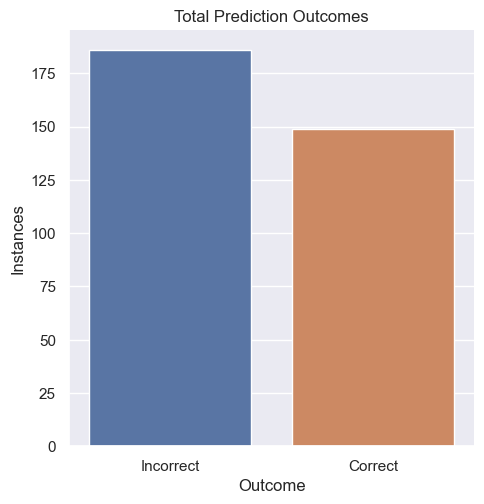

In [519]:
sns.set(style='darkgrid')
plt.figure(figsize=(5, 3))
ax = sns.catplot(data=analysis_df, x='correct', kind='count')
ax.set(xlabel="Outcome", ylabel="Instances", title="Total Prediction Outcomes", xticklabels=['Incorrect', 'Correct'])
plt.savefig("Visualizations/Total Prediction Outcomes.png", bbox_inches = 'tight')
plt.show()

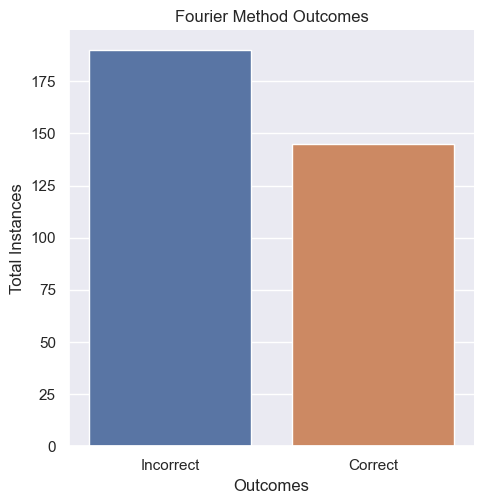

In [521]:
ax = sns.catplot(data=analysis_df, x='fourier_correct', kind='count')
ax.set(xlabel="Outcomes",  ylabel="Total Instances", title="Fourier Method Outcomes", xticklabels=['Incorrect','Correct'])
plt.savefig("Visualizations/Fourier Method Outcomes.png", bbox_inches = 'tight')

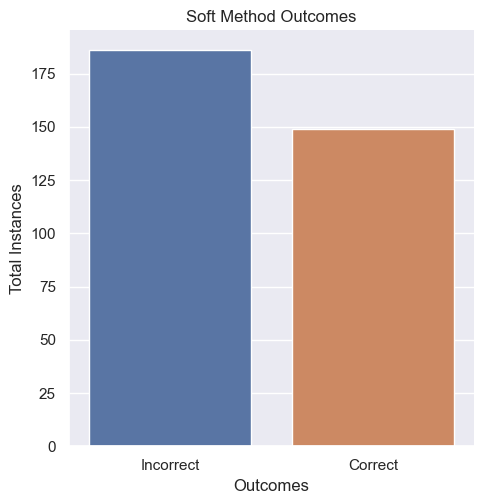

In [522]:
ax = sns.catplot(data=analysis_df, x='soft_correct', kind='count')
ax.set(xlabel="Outcomes",  ylabel="Total Instances", title="Soft Method Outcomes", xticklabels=['Incorrect','Correct'])
plt.savefig("Visualizations/Soft Method Outcomes.png", bbox_inches = 'tight')

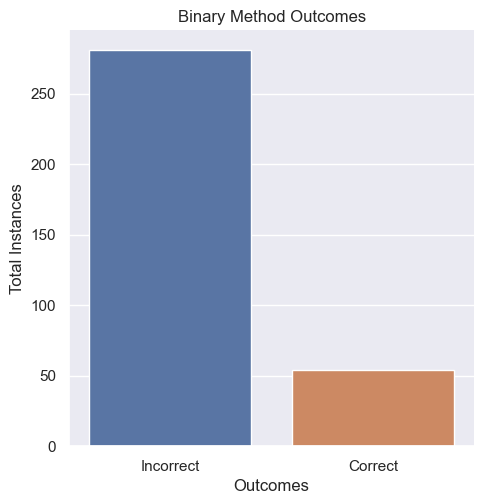

In [523]:
ax = sns.catplot(data=analysis_df, x='binary_correct', kind='count')
ax.set(xlabel="Outcomes",  ylabel="Total Instances", title="Binary Method Outcomes", xticklabels=['Incorrect','Correct'])
plt.savefig("Visualizations/Binary Method Outcomes.png", bbox_inches = 'tight')

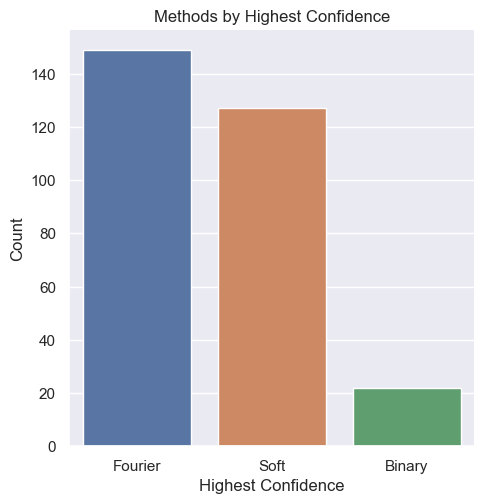

In [525]:
ax = sns.catplot(data=analysis_df, x="best-method", kind="count")
ax.set(xlabel="Highest Confidence", ylabel="Count", title="Methods by Highest Confidence", xticklabels=['Fourier', 'Soft', 'Binary'])
plt.savefig("Visualizations/Soft Confidence Score.png", bbox_inches='tight')

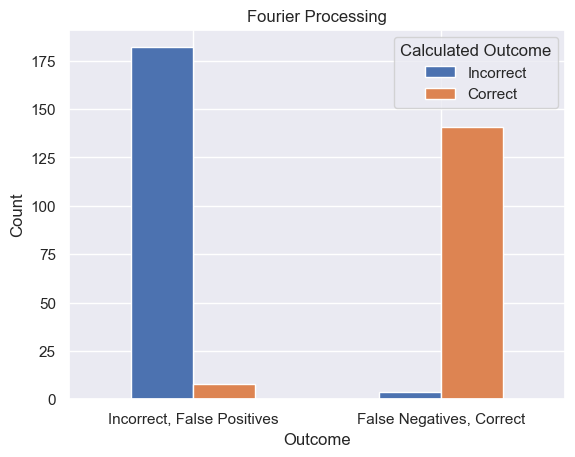

In [537]:
crosstab = pd.crosstab(analysis_df['fourier_correct'],analysis_df['correct'])
ax = crosstab.plot.bar(stacked=False, rot=0)
ax.set(xlabel="Outcome", ylabel="Count", title="Fourier Processing", xticklabels=["Incorrect, False Positives", "False Negatives, Correct"])
ax.legend(title="Calculated Outcome", labels=['Incorrect', 'Correct'])
plt.savefig("Visualizations/Fourier Processing Outcomes.png", bbox_inches = 'tight')

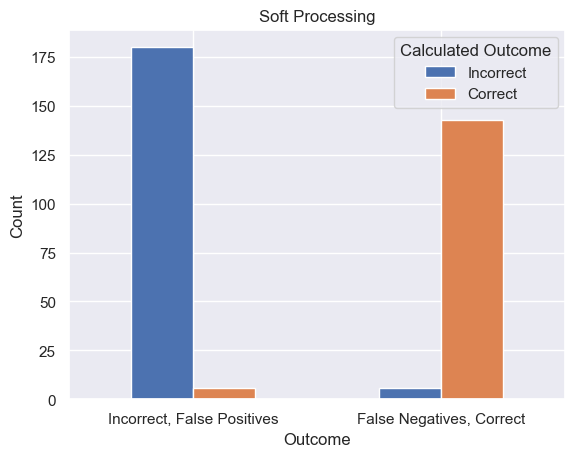

In [538]:
crosstab = pd.crosstab(analysis_df['soft_correct'],analysis_df['correct'])
ax = crosstab.plot.bar(stacked=False, rot=0)
ax.set(xlabel="Outcome", ylabel="Count", title="Soft Processing", xticklabels=["Incorrect, False Positives", "False Negatives, Correct"])
ax.legend(title="Calculated Outcome", labels=['Incorrect', 'Correct'])
plt.savefig("Visualizations/Soft Processing Outcomes.png", bbox_inches = 'tight')

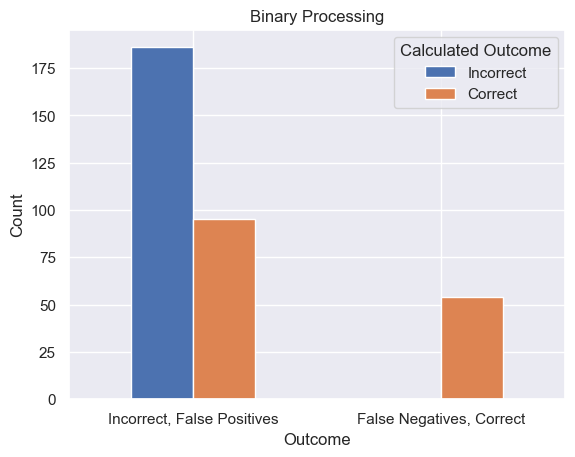

In [539]:
crosstab = pd.crosstab(analysis_df['binary_correct'],analysis_df['correct'])
ax = crosstab.plot.bar(stacked=False, rot=0)
ax.set(xlabel="Outcome", ylabel="Count", title="Binary Processing", xticklabels=["Incorrect, False Positives", "False Negatives, Correct"])
ax.legend(title="Calculated Outcome", labels=['Incorrect', 'Correct'])
plt.savefig("Visualizations/Binary Processing Outcomes.png", bbox_inches = 'tight')

In [5]:
avg_fourier = analysis_df['fourier_confidence_score'].mean()

In [6]:
avg_soft = analysis_df['soft_confidence_score'].mean()

In [7]:
avg_binary = analysis_df['binary_confidence_score'].mean()

In [8]:
print(avg_fourier, avg_soft, avg_binary)

0.841846684402237 0.840929637111592 0.8102447211749085


# Old Test for Fourier Visualization

In [ ]:
"""#Turn into Grayscale
new_img_array = np.array(im)
new_img_array_grayscale = new_img_array[:, :, :3].mean(axis=2)
plt.set_cmap("gray")
#Call in 2D Fourier Transformation
ft = calculate_2dft(new_img_array_grayscale)
plt.subplot(121)
plt.imshow(new_img_array_grayscale)
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.show()
plt.imshow(np.angle(ft)**2)
plt.imshow(np.log(abs(ft)))"""